<a href="https://colab.research.google.com/github/aarav-2/Deep-Learning-assignments/blob/main/Day2_Task_Sentiment_classification_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! python -m spacy download en
! pip install wordcloud
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false -O sentiment.tsv

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
--2024-09-21 17:18:57--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447540 (437K) [application/octet-stream]
Saving to: ‘sentiment.tsv’

sentiment.tsv       100%[===================>] 437.05K 

# Task: sentiment classification

The task is to classify one-sentence long movie reviews/opinions according to the sentiment they express. There are only two categories: positive and negative sentiment.


> "Data source: [UMICH SI650 - Sentiment Classification](https://www.kaggle.com/c/si650winter11/data)

> Training data: 7086 lines.
  
> Format: 1|0 (tab) sentence

> Test data: 33052 lines, each contains one sentence.

> The data was originally collected from opinmind.com (which is no longer active)."

The data is in the file "sentiment.tsv".

# Loading the data

In [2]:
import pandas as pd

df = pd.read_csv('sentiment.tsv', sep='\t',
                 quoting=3, # Quotes are _never_ field separators
                 header=None)

df.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [3]:
df = df[[1,0]] # rearrange columns

df.rename(columns={1:"text", 0:"sentiment"}, inplace=True) # rename columns

df.head()

,text,sentiment
0,The Da Vinci Code book is just awesome.,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.,1
3,i liked the Da Vinci Code a lot.,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Splitting into train, validation and test

Before doing anything else (!) we divide our data into train, validation and test parts,

In [37]:
# Import the necessary function from Scikit
from sklearn.model_selection import train_test_split

# Please observe, that we can only do a split into two
# hence our best option is to call the function twice in a chain
# Don't forget to fix the random seed also, eg to 13, since that is a lucky number! :-)
df_train, df_test_valid = train_test_split(df, test_size=0.4, random_state=13)

df_test, df_valid = train_test_split(df_test_valid, test_size = 0.5, random_state = 13)

assert len(df_train)==4251 and len(df_valid)==1418 and len(df_test)==1417
print(len(df_train), len(df_valid), len(df_test))

4251 1418 1417


# Inspecting the data

In [38]:
df_train.describe()

,sentiment
count,4251.000000
mean,0.556575
std,0.496847
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


We can examine the lengths of sentences as well.

In [39]:
n_chars = df_train.text.apply(lambda x: len(x))

n_chars.describe()

,text
count,4251.000000
mean,60.363914
std,37.827441
min,18.000000
25%,32.000000
50%,48.000000
75%,77.000000
max,203.000000


The first sentence with the maximal length:

In [40]:
long_sentence = df_train.loc[n_chars.idxmax(), "text"]
long_sentence

'A mother in Georgia wants her local school board to take Harry Potter out of the schools and libraries because, in her opinion, reading Harry Potter leads to witchcraft, which according to her is evil...'

# Extra task: Let's do a word cloud!

Let us visualize together and separately (by category) the sentences!

Tool: https://github.com/amueller/word_cloud


Good example: https://github.com/amueller/word_cloud/blob/master/examples/simple.py



In [41]:
# Helper function for displaying a word cloud
# Input: one _UNIFIED_, space separated string!
# Protip: https://www.tutorialspoint.com/python/string_join.htm
def do_wordcloud(text):
    from wordcloud import WordCloud

    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


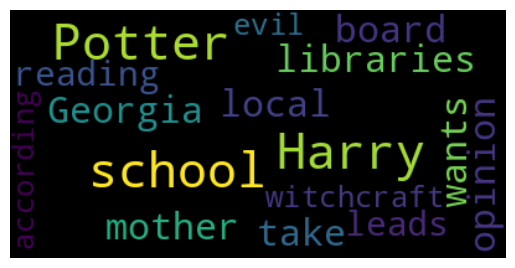

In [42]:
### TASK !!! ####
#Put here the world cloud!
do_wordcloud(long_sentence)




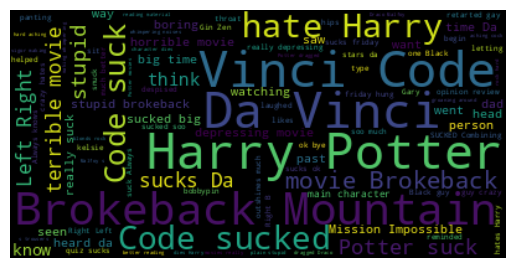

In [43]:
### TASK !!! ####
# Here only the cloud for sentences with negative sentiment!
# Help: the shape of the DataFrame with only the negative sentences is: (2975, 2)
# Source: https://pandas.pydata.org/pandas-docs/stable/indexing.html

df_neg = df[df['sentiment'] == 0]

# Combine all the negative sentiment text into one unified string
unified_neg_text = ''.join(df_neg.text.values)
do_wordcloud(unified_neg_text)


# Bag of words (BoW) representation of the texts

We will represent each text as a (sparse) vector of lemma (word root) counts for frequent lemmas in the training data.

For tokenization and lemmatization we use [spaCy](https://spacy.io/), an open source Python NLP library, which can produce a list of unique lemma ids from the text.

In [44]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# We only need the tokenizer, all higher functions are now unnecessary.
# If this load does not work, use "en" instead

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


spaCy can produce spaCy Doc objects from texts that contain their linguistic analysis, among others lemmas and their unique spaCy string ids.

In [45]:
doc = nlp(long_sentence)
type(doc)

spacy.tokens.doc.Doc

In [46]:
print([token.lemma_ for token in doc ]) # Lemmas

['a', 'mother', 'in', 'Georgia', 'want', 'her', 'local', 'school', 'board', 'to', 'take', 'Harry', 'Potter', 'out', 'of', 'the', 'school', 'and', 'library', 'because', ',', 'in', 'her', 'opinion', ',', 'read', 'Harry', 'Potter', 'lead', 'to', 'witchcraft', ',', 'which', 'accord', 'to', 'she', 'be', 'evil', '...']


In [47]:
print([token.lemma for token in doc]) # Connected unique ID-s

[11901859001352538922, 7963322251145911254, 3002984154512732771, 309210702643012516, 7597692042947428029, 4115755726172261197, 16319852998319793599, 13293160603192985325, 14899812206273857344, 3791531372978436496, 6789454535283781228, 5164779919001708464, 2416965663249996073, 1696981056005371314, 886050111519832510, 7425985699627899538, 13293160603192985325, 2283656566040971221, 1785747669126016609, 16950148841647037698, 2593208677638477497, 3002984154512732771, 4115755726172261197, 14536103007527724270, 2593208677638477497, 11792590063656742891, 5164779919001708464, 2416965663249996073, 82546335403996757, 3791531372978436496, 17905374590688478165, 2593208677638477497, 7063653163634019529, 701735504652304602, 3791531372978436496, 6740321247510922449, 10382539506755952630, 15036397985088571056, 10875615029400813363]


Now we have to convert these lists into BoW vectors. We could "roll our own", but, fortunately, scikit-learn has a feature extractor doing exactly that, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) so, for the sake of simplicity, we will use that along with spaCy.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma for token in nlp(s)], #spaCy for analysis
                     min_df= 0.001) # We ignore the lemmas with low document frequency
cv

CountVectorizer(analyzer=<function <lambda> at 0x79328e11c4c0>, min_df=0.001)

In [49]:
sents = ["I hate this movie.", "The movie is the worst I've seen."]
bows = cv.fit_transform(sents).toarray()
# A CountVectorizer produces a sparse matrix, we convert to ndarray
bows

array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 2, 0, 1, 1, 1, 1, 1, 1]])

Using the CountVectorizer we convert the text columns of our train, validation and  test data into three sparse matrices.

In [50]:
bows_train = cv.fit_transform(df_train.text)
bows_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)
bows_train

BoW length: 378


<4251x378 sparse matrix of type '<class 'numpy.int64'>'
	with 48377 stored elements in Compressed Sparse Row format>

In [51]:
bows_valid = cv.transform(df_valid.text)
bows_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test = cv.transform(df_test.text)
bows_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

# Task: The model

We build a feed-forward neural network in Keras for our binary classification task, which will be trained with cross-entropy loss and minibatch SGD.

In [54]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


# USE KERAS FUNKTIONAl API!


# Parameters
############

hidden_size = 100

# Model
#######
# Define (instantiate) the input layer!
# Give the shape parameter the length of a BoW vector as length
# WARNING: shape only accepts a tuple, even is one dimensional!
inputs = Input (shape=(bow_length,))

# Hidden layer
##############
# Define a fully connected hidden layer that can be modified by the parameters above!
# Use the ReLU activation function
# Give the inputs to the hidden layer
# Please be aware, that in Keras Functional, the parameters defining the layer are
# "instantiation" parameters, but the input of the layer is already a "call" parameter!
# (The magic lies in the brackets... ;-)

hidden_output = Dense(hidden_size, activation='relu')(inputs)

# Softmax
#########
# Define the output softmax
# (Which is a fully connected layer with activation accordingly...)
# Please remember, we have exactly two classes!
# (We choose to use this generalized, Softmax approach...)
# We feed the layer with the output of the hidden one.

predictions = Dense(2, activation='softmax')(hidden_output)

# Whole model
##############
# Nothing more is left, than to instantiate the model
# Please ensure input and output is right!

model = Model(inputs=inputs, outputs=predictions)

# Optimization
##############
# For now, we stick to this.
optimizer = SGD(learning_rate=0.1)


# Compilation and teaching
##########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # use this cross entropy variant
                                                      # since the input is not one-hot encoded
              metrics=['accuracy']) #We measure and print accuracy during training

# Training

In [57]:
model.fit(x=bows_train.toarray(), # convert bows_train to a dense matrix
          y=df_train.sentiment.values,
          validation_data=(bows_valid.toarray(), df_valid.sentiment.values), # convert bows_valid to a dense matrix
          epochs=10,
          batch_size=200)

# Please don't just run, understand!

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6540 - loss: 0.6567 - val_accuracy: 0.8900 - val_loss: 0.5034
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8984 - loss: 0.4543 - val_accuracy: 0.9295 - val_loss: 0.3496
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9439 - loss: 0.3142 - val_accuracy: 0.9478 - val_loss: 0.2525
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9558 - loss: 0.2255 - val_accuracy: 0.9669 - val_loss: 0.1933
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.1686 - val_accuracy: 0.9697 - val_loss: 0.1562
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9722 - loss: 0.1361 - val_accuracy: 0.9718 - val_loss: 0.1320
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9789 - loss: 0.1109 - val_accuracy: 0.9718 - val_loss: 0.1141
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9779 - loss: 0.1013 - val_accuracy: 0.9732 - val_loss

# Prediction

In [59]:
print("=== INTERACTIVE DEMO ===")
while True:
    s = input("Enter a short text to evaluate or press return to quit: ")
    if s == "":
        break
    else:
        bow = cv.transform([s])
        prob_pred = model.predict(bow.toarray())

        print(f"Positive vs negative sentiment probability: {prob_pred[0,1]} vs {prob_pred[0,0]}")

=== INTERACTIVE DEMO ===
Enter a short text to evaluate or press return to quit: hello wolrd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Positive vs negative sentiment probability: 0.5192864537239075 vs 0.4807136058807373
Enter a short text to evaluate or press return to quit: hello world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive vs negative sentiment probability: 0.4739222228527069 vs 0.5260778069496155
Enter a short text to evaluate or press return to quit: good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive vs negative sentiment probability: 0.6166384220123291 vs 0.38336166739463806
Enter a short text to evaluate or press return to quit: happpy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive vs negative sentiment probability: 0.5192864537239075 vs 0.4807136058807373
Enter a short text to evaluate or press return to quit: the beset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive vs negative sentiment probability: 0.512927234172821 vs 0.48707276582717896
Enter a short text to evaluate o